*Your Name*

*Collaborator's Names*

# Writing to File in Parallel with Locks

Programs that are pleasantly parallel don't have to have their processes share any information about their "state". Unfortunately, not every problem we want to solve can be pleasantly parallel.

Its common for our programs to need to write something to file. As we'll see in this workbook, multiple processes writing to the same file at the same time is a recipe for disaster. We'll learn a couple ways to handle this problem and examine their impact on our program's weak scaling.

Recall that weak scaling is useful as a measure of parallel overhead. Parallel overhead can't be avoided, but it can be minimized. Minimizing parallel overhead is crucial if we want out programs to efficiently handle more and more amounts of work.

## File Writing Conflicts

First we'll explore the worst case scenario: multiple processes writing to the same file at the same time. 

Take the following function as an example:

In [9]:
import os

def work(max_count, filename):

    for n in range(max_count):
        
        # Check for data already present
        if os.path.isfile(filename):
            f = open(filename, "r")
            try:
                nbr = int(f.read())
            except ValueError as err:
                # The flush argument helps print messages appear correctly
                # when multiple processes are trying to print
                print("File read error, starting to count from 0; error: " + str(err),
                      flush=True)
                nbr = 0
        else:
            print("File doesn't exist, starting to count from 0.", flush=True)
            nbr = 0 

        # Update data
        next = nbr + 1

        # Write update (overwrite existing data)
        f = open(filename, "w")
        f.write(str(next) + '\n')
        f.close()


This example is very artificial, but it mimics a case where processes are sharing information back and forth by writing it to file. This function makes a process check that file for the current result (`nbr = int(f.read())`), update it (`next = nbr + 1`), and then write out its update (`f.write(str(next) + '\n')`). In theory, another process can then read in these results and perform its own update.

If everything goes correctly, the number written to file should be the sum of each processes' value for `max_count`.

---
### Exercises

1. Run the `work` function on **one** process, with `max_count = 1000` and `filename = serial.txt`. What number is in this file when the function finishes? Does it meet your expectations?

Warning: If you run `work` multiple times when `serial.txt` already exists, the value inside will keep going up!

*Answer here*

In [10]:
!rm serial.txt

In [11]:
work(1000, "serial.txt")

with open("serial.txt", "r") as f:
    print(f.read())


File doesn't exist, starting to count from 0.
1000



It should be 1000, and is 1000.

2. Lets run this function on **two** processes using `Pool.map`. Each process should run with `filename = parallel.txt`. They should get `max_counts` of 1,000 and 2,000.

    This is our first time using `Pool.map` with a function that takes multiple arguments. We can use `functools.partial` to fix the values of arguments other than the first (i.e., we can set parameters other than `max_counts` to values of our choosing):

    `partial_func = functools.partial(work, filename="parallel.txt")`

    We can now use `partial_func` like any other function. It's one argument is `max_counts`.

Warning: If you run `work` multiple times when `parallel.txt` already exists, the value inside will keep going up!

In [12]:
import multiprocessing
import functools

with multiprocessing.Pool(processes=2) as p:
    partial_func = functools.partial(work, filename="parallel.txt")
    p.map(partial_func, [1000, 2000])

File doesn't exist, starting to count from 0.File doesn't exist, starting to count from 0.

File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for i

In [13]:
!cat parallel.txt
!rm parallel.txt

1031


3. You probably got an awful lot off errors! Check the number stored in `parallel.txt`. What value is written there? Given what was explained at the start of this section, what number do you expect to be there?

*Answer here*

It should be 3000 (1000 + 2000) but its only 392 (this number will be different)

---
### Explanation

When both processes first start running the `work` function, they see that no file named `parallel.txt` currently exists. Therefore, each process starts trying to count from zero. You should have seen the message "File doesn't exist, starting to count from 0" printed twice, reflecting this behavior.

It's arbitrary which process will succeed in writing to file first, an issue known as a "race condition." As one process is in the middle of writing, its possible that the other process will read the partially saved results. This partial data cannot be read properly (it appears as an empty string), causing the exception. We've structured our code so that when a process can't read the file's data, it assumes it should start the count at 0. Therefore, when the processes read the file as the other as writing, they reset the counter! This is why the final count is much lower than we expect.

Race conditions such as these can introduce bugs to our code that are hard to track down, as they are not reliably reproducible. We can use "locks" to prevent multiple processes from accessing the same resource (e.g. a file or variable) at the same time, preventing the race condition from creating bugs. We'll learn some implementations for locks in the following section.


---
## Locking File Access

We can use the `fasteners` module to ensure that only one process may write to a file at a time. This library makes use of *decorators*, a feature of the Python language that allows us to easily extend the behavior of functions.

Decorators make adding the fastener behavior easy:
```python
from fasteners import interprocess_locked

@interproess_locked('/tmp/local/tmp_lock') # this is the decorator
def work(max_count, filename):
    ...
```
With this decorator, a process will not execute the `work` function until is has acquired the lock. There are other ways to use the `fasteners` module that you can investigate if you wish.

We have to provide a file name in which to store the lock information. We call this file `tmp_lock` and store it in the `/tmp/local` directory. The name of this file has nothing to do with the filename that `work` is using.

This is a special directory on the HPCC that is faster to access than your home, research, or scratch file spaces. The home, research, and scratch spaces are referred to as *networked filesystems*; any node can access files stored here thanks to the HPCC's internal network. The directory `/tmp/local` is a [*local filesystem*](https://docs.icer.msu.edu/Local_File_Systems/) and is **only accessible to the node you're running on.** If you're using processes from multiple nodes, you'll need to change the location of your lock file to something like your home directory (this will never happen with OnDemand).

The advantages of writing our lock file to `/tmp/local` are:
1. the file gets automatically deleted when our SLURM job ends
2. the local filesystem is generally faster to access than the networked filesystems

---
### Exercises

1. Redefine the `work` function from the previous section and add the `interprocess_locked` decorator. Then, run `work` with two processes using `Pool.map` as before. This time, have `work` use `filename = parallel_locked.txt`.

In [14]:
from fasteners import interprocess_locked

@interprocess_locked('/mnt/home/kopenhaf/tmp_lock')
def work(max_count, filename):
    
    for n in range(max_count):
        
        # Check for data already present
        if os.path.isfile(filename):
            f = open(filename, "r")
            try:
                nbr = int(f.read())
            except ValueError as err:
                # The flush argument helps print messages appear correctly
                # when multiple processes are trying to print
                print("File read error, starting to count from 0; error: " + str(err),
                      flush=True)
                nbr = 0
        else:
            print("File doesn't exist, starting to count from 0.", flush=True)
            nbr = 0 

        # Update data
        next = nbr + 1

        # Write update (overwrite existing data)
        f = open(filename, "w")
        f.write(str(next) + '\n')
        f.close()

In [15]:
with multiprocessing.Pool(processes=2) as p:
    partial_func = functools.partial(work, filename="parallel_locked.txt")
    p.map(partial_func, [1000, 2000])

File doesn't exist, starting to count from 0.


2. Check the contents of `parallel_locked.txt`. Does it now match your expectations?

*Answer here*

In [16]:
!cat parallel_locked.txt
!rm parallel_locked.txt

3000


3. Perform a weak scaling analysis for the locked version of `work`; that is, keep `max_count` the same for all processes (say, 1000 iterations each) but change the number of processes involved from 1 to 8. Plot the results similar to how you plotted the weak scaling analysis in last week's workbook.

In [27]:
import numpy as np
from time import perf_counter
n_measurements = 10
weak_measurements = np.empty(8)

for nprocs in range(1,9):
    timings = np.empty(n_measurements)

    for i in range(n_measurements):
        
        start = perf_counter()

        with multiprocessing.Pool(processes=nprocs) as p:
            partial_func = functools.partial(work, filename="parallel_locked.txt")
            p.map(partial_func, [1000]*nprocs)
        
        end = perf_counter()
        timings[i] = end - start

    weak_measurements[int(nprocs)-1] = timings.mean()
    

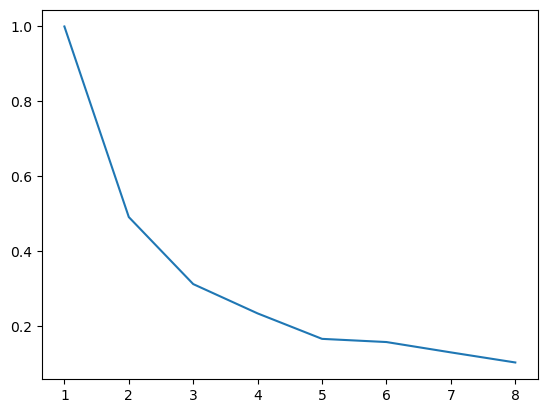

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(1,9), weak_measurements[0]/weak_measurements)

4. Last week we performed a weak scaling analysis for a pleasantly parallel problem. Now that we've added locks, is the weak scaling efficiency better or worse than for a pleasantly parallel problem? How do these two efficiencies depend on the number of processes?

*Answer here*

---
## Designing Away the Lock

